## Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import  train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import warnings
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import json
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve
import scipy.stats as stats
import shap
warnings.filterwarnings('ignore')

%matplotlib inline
pd.set_option('display.max_columns', None)

c:\Users\artur\class_transactions\class_transactions\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the data. In this case, we have a .csv file given by the client for us to study and model on. Each row represents a transaction.

In [2]:
original_data = pd.read_csv(r"C:\Users\artur\class_transactions\data\creditcard.csv")

Checking the data, we can see that there are 31 columns: one column containing a time count, in seconds, representing the time passed after the first transaction in the dataset (hence considered the epoch). 28 columns representing 28 variables regarding the client's features or the specific transaction (all anonymized using, for example, PCA), one column containing the Amount (value in currency (presumably EUR)) of the transaction and the final column named Class that represents if the transaction was a fraud (1) or not (0). Therefore, we have a binary classification problem.

In [14]:
original_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Checking if there is any null row

In [5]:
original_data.isnull().sum().sum()

0

Checking if there is any duplicated row. Since 1081 were found, we are dropping them using drop_duplicates()

In [3]:
original_data.duplicated().sum()

1081

In [3]:
original_data.drop_duplicates(inplace=True)

In our dataset there are 283726 transactions (rows) where only 473 of them are actual frauds. Therefore, we have in our hands an extremely imbalanced classification problem.

In [91]:
original_data["Class"].value_counts()

Class
0    283253
1       473
Name: count, dtype: int64

From the start, splitting the data set into training and testing. We are only returning to the testing data
after having our trained model to see how we perform with unseen data.

We need to be careful to have fraudulent transactions in both training and testing datasets when splitting the data. In order to do that, we are splitting the data in a stratified way. We are splitting the data making sure that 15% of it is going to testing and 85% to training.

In [4]:
X = original_data.drop(["Class"], axis=1)
y = original_data[["Class"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=original_data["Class"])

perc_original = (original_data[["Class"]].value_counts()[0] / (original_data[["Class"]].value_counts()[0] + original_data[["Class"]].value_counts()[1]))*100
perc_train = (y_train.value_counts()[0] / (y_train.value_counts()[0] + y_train.value_counts()[1]))*100
perc_test = (y_test.value_counts()[0] / (y_test.value_counts()[0] + y_test.value_counts()[1]))*100

print(f"Prop. of non-fraud transactions on original data: {perc_original:.02f}")
print(f"Prop. of non-fraud transactions on training data: {perc_train:.02f}")
print(f"Prop. of non-fraud transactions on testing data: {perc_test:.02f}")

Prop. of non-fraud transactions on original data: 99.83
Prop. of non-fraud transactions on training data: 99.83
Prop. of non-fraud transactions on testing data: 99.83


In [5]:
training_data = pd.concat([X_train, y_train], axis=1)
testing_data = pd.concat([X_test, y_test], axis=1)
training_data.to_csv(r"C:\Users\artur\class_transactions\data\training_data.csv")
testing_data.to_csv(r"C:\Users\artur\class_transactions\data\testing_data.csv")

Let's contunue our exploration using only the training data.

In [97]:
training_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
84206,60205.0,1.233270,0.040032,0.134008,0.272556,0.054883,0.244832,-0.223827,0.205438,0.030645,0.097945,0.747922,0.194980,-0.914311,0.667082,0.782968,0.507359,-0.623484,-0.070518,0.132755,-0.170326,-0.247630,-0.773342,0.067363,-0.848483,0.182254,0.162467,-0.025604,-0.005840,0.89,0
172458,121108.0,-0.783823,0.927366,-1.043634,1.065041,2.369544,-0.542584,1.287016,-0.239198,-0.713867,-0.492404,-1.099156,-0.110140,0.844858,-1.324375,-0.126531,-0.532871,0.992273,0.446716,0.865553,0.099626,-0.040171,0.392896,0.202957,-0.071165,0.310242,-0.355486,0.406562,0.220590,1.00,0
98765,66807.0,1.266865,0.481231,-0.119466,1.112353,0.026039,-1.193853,0.555428,-0.354063,-0.271385,0.044644,-0.370122,0.188277,-0.056153,0.575710,0.688439,-0.214040,-0.309140,-0.362971,-0.254551,-0.148044,0.005526,0.059630,-0.149126,0.405325,0.848880,-0.296838,-0.009259,0.011754,6.79,0
259534,159160.0,-2.083682,2.108832,-2.223863,-0.015583,-0.431835,-1.695080,-0.477952,1.284506,-0.298766,-1.007729,-1.022767,0.641899,0.744459,0.127578,0.555655,0.483325,1.016097,0.753935,-0.176987,-0.502417,0.377555,0.998111,0.182312,-0.076132,-0.136755,-0.148385,-0.307083,-0.069161,2.15,0
134141,80661.0,-1.760925,1.387821,-0.050880,1.336324,-2.605606,1.388641,1.783186,0.726618,-0.684235,-0.278191,0.977074,0.811208,-0.585396,0.788272,-0.414001,-0.632589,0.717522,-0.114091,0.881953,-0.260697,-0.044770,0.372187,0.151773,0.247016,-0.023620,-0.235129,0.459238,-0.043548,462.72,0


Checking our training dataset, one interesting thing to notice is that the Amount of the transactions in mainly values not so high: 75% of these values are below 77.85 EUR.

In [98]:
training_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,241167.0,94863.517513,47482.675433,0.000000,54221.000000,84773.000000,139335.000000,172792.000000
V1,241167.0,0.004549,1.946467,-56.407510,-0.917019,0.018353,1.315534,2.454930
V2,241167.0,-0.005827,1.647758,-72.715728,-0.602023,0.063850,0.800795,22.057729
V3,241167.0,0.003052,1.506205,-33.680984,-0.887192,0.179384,1.028446,9.382558
V4,241167.0,-0.002121,1.415984,-5.683171,-0.849552,-0.022076,0.740945,16.875344
V5,241167.0,0.004244,1.359653,-42.147898,-0.690098,-0.052914,0.614355,34.801666
V6,241167.0,-0.001349,1.324141,-26.160506,-0.768418,-0.275187,0.397880,22.529298
V7,241167.0,0.000545,1.202028,-43.557242,-0.553309,0.040415,0.571423,36.677268
V8,241167.0,-0.001257,1.176904,-73.216718,-0.208683,0.022238,0.325529,20.007208
V9,241167.0,-0.002436,1.095128,-13.434066,-0.644412,-0.052712,0.594484,15.594995


In [6]:
df = training_data.copy()

In [100]:
df.isnull().sum().sum()

0

In [101]:
df.duplicated().sum()

0

The Time column has a time-series characteristic, which for us, in the type of challenge we are dealing with, is not important. Let's drop this feature already.

In [7]:
df.drop(columns=["Time"], inplace=True)

### Feature Engineering
One of the first steps in feature engineering is to remove the features that are correlated to each other for various reasons: optimize computation capacity, interpretation of results and feature importances and, depending on the model selected, correlated features are a problem.

To compare features correlations, we are going to use spearman coefficient, which is a nonparametric method that considers monotonic relations between variables, not only linear as perason's coefficient does. The spearman coeff ranges from -1 to 1, limits in which the correlation is the strongest. According to literature (Kuckartz et al.: Statistik, Eine verständliche Einführung, 2013, p. 213) spearman coeff values above 0.5 (in absolute) start to show a strong correlation between the variables. Hence, this is the threshold that we will be considering in order to check if a feature is correlated to another. We are algo going to calculate the p-value associated to the spearman coeff stat to check if it is statistically significant. If p-value is <5%, we reject the null hypothesis and conclude that it is significant.

In order to analyze the spearman coeff, we need to normalize the data (they need to be in the same scale). To do this, we are using MinMaxScaler.

In [14]:
df_rel = df
features = list(df_rel.columns)
features.remove('Class')

mms = MinMaxScaler()

df_rel[features] = mms.fit_transform(df_rel[features])

In [120]:
df_rel.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
84206,0.979246,0.767681,0.785235,0.264012,0.548447,0.542318,0.540085,0.787589,0.463836,0.510748,0.329761,0.710121,0.470767,0.668483,0.511585,0.690793,0.713014,0.648442,0.574573,0.387543,0.557488,0.473955,0.666434,0.290114,0.588137,0.451987,0.649232,0.256922,0.000045,0
172458,0.944978,0.777043,0.757888,0.299143,0.578528,0.526146,0.558915,0.782820,0.438188,0.498534,0.219923,0.698564,0.640557,0.601523,0.423495,0.641701,0.759961,0.684016,0.631887,0.391719,0.560832,0.528360,0.668448,0.403542,0.595321,0.367380,0.661679,0.261893,0.000051,0
98765,0.979816,0.772336,0.779349,0.301240,0.548072,0.512770,0.549797,0.781587,0.453431,0.509646,0.263276,0.709867,0.553594,0.665411,0.502430,0.656748,0.722147,0.628328,0.544281,0.387887,0.561569,0.512813,0.663219,0.473073,0.625556,0.376960,0.649702,0.257309,0.000345,0
259534,0.922895,0.789510,0.730481,0.251239,0.542122,0.502475,0.536917,0.799164,0.452488,0.487872,0.224466,0.727048,0.630867,0.650343,0.489569,0.689659,0.760653,0.705145,0.550347,0.382405,0.567566,0.556593,0.668141,0.402817,0.570230,0.401210,0.641124,0.255533,0.000109,0
134141,0.928378,0.781902,0.780941,0.311168,0.513873,0.565809,0.565099,0.793180,0.439209,0.502966,0.343388,0.733461,0.502513,0.672558,0.395652,0.636994,0.751978,0.645445,0.633170,0.386145,0.560758,0.527394,0.667688,0.449972,0.576581,0.387041,0.663197,0.256095,0.023540,0


Plotting a heatmap to check what feature combinations have a spearman coeff above 0.5 (abs). We can see that there are not many cases where this happens.

In [122]:
df_rel.drop("Class", axis=1).corr(method='spearman').style.apply(lambda x: ["background: red" if abs(v) > 0.5 else "" for v in x], axis = 1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
V1,1.000000,-0.381375,-0.414210,0.101185,-0.110307,-0.085113,-0.230664,-0.234032,0.138698,0.233472,0.012624,0.004620,0.047910,-0.024379,0.029504,0.037907,-0.056667,-0.045878,0.031648,-0.209095,-0.063667,-0.029489,0.145712,-0.001248,0.047843,0.006395,-0.106842,-0.210625,-0.088007
V2,-0.381375,1.000000,0.074516,0.155848,0.346063,-0.110804,0.428951,0.004444,-0.078228,-0.213811,-0.011799,0.051489,0.029187,0.088414,0.040409,0.069247,-0.003448,0.012627,0.002245,0.040532,-0.097563,-0.056987,-0.096116,0.013272,-0.086672,0.035035,0.131038,0.138927,-0.502611
V3,-0.414210,0.074516,1.000000,0.061083,-0.226444,0.170539,-0.073867,0.165051,-0.030705,-0.072515,0.056254,-0.050120,0.006807,-0.129110,0.050973,-0.045606,-0.035843,-0.044652,-0.016677,0.107321,-0.039059,0.005686,-0.138602,0.000398,0.032175,-0.016147,0.141378,0.181609,0.000229
V4,0.101185,0.155848,0.061083,1.000000,0.020683,0.074628,0.061149,-0.009636,0.105507,0.025079,-0.013405,0.148812,-0.024610,0.101222,0.054490,-0.041191,0.047938,0.022933,-0.017905,-0.008354,0.039982,-0.003946,0.009545,-0.008954,0.060701,-0.063314,-0.032699,0.005233,-0.020760
V5,-0.110307,0.346063,-0.226444,0.020683,1.000000,-0.007274,0.429996,-0.053616,-0.056869,-0.157444,0.008611,-0.046742,0.019602,0.036555,-0.039839,-0.006674,-0.144019,-0.016650,0.012011,0.055975,-0.040456,-0.011346,-0.107537,-0.023238,-0.014350,0.030384,0.013372,-0.027655,-0.314907
V6,-0.085113,-0.110804,0.170539,0.074628,-0.007274,1.000000,-0.292882,0.444045,0.029819,0.064471,0.059674,0.037742,-0.003997,-0.069101,-0.047154,-0.020350,-0.028015,0.053039,0.032060,0.052904,0.035550,0.040501,-0.051126,-0.133444,-0.009652,-0.023995,0.075319,0.021438,0.205438
V7,-0.230664,0.428951,-0.073867,0.061149,0.429996,-0.292882,1.000000,-0.386940,-0.100427,-0.210916,0.002484,-0.043617,-0.016284,0.060721,-0.052131,-0.120177,-0.144826,-0.069582,0.000895,0.159993,-0.021038,-0.022853,-0.186188,-0.014998,-0.045886,0.017052,-0.096418,0.056735,-0.029619
V8,-0.234032,0.004444,0.165051,-0.009636,-0.053616,0.444045,-0.386940,1.000000,-0.001998,-0.119434,0.053415,0.104370,-0.145553,0.039610,-0.016042,0.087246,0.073063,0.066066,-0.034271,0.008058,0.076020,0.021087,0.075213,-0.024456,-0.073779,-0.007694,0.191987,0.091141,0.002838
V9,0.138698,-0.078228,-0.030705,0.105507,-0.056869,0.029819,-0.100427,-0.001998,1.000000,-0.294549,-0.031590,0.104528,-0.047882,-0.032045,-0.003931,-0.031102,-0.068618,-0.013312,0.001589,-0.016385,-0.064858,0.002756,0.074851,-0.000444,-0.022790,0.027589,-0.001518,-0.103419,-0.077146
V10,0.233472,-0.213811,-0.072515,0.025079,-0.157444,0.064471,-0.210916,-0.119434,-0.294549,1.000000,0.034083,-0.163489,0.000960,0.006888,-0.028936,-0.053362,-0.148387,-0.053017,0.040521,-0.088479,-0.046312,0.040778,0.077854,-0.007815,-0.018106,-0.027062,-0.020154,-0.130056,0.055913


Filtering only the feature pairs where spearman coeff in above 0.5 (abs) and stating its p-value.

V2 and Amount have a strong and significant (p-value < 5%) correlation, such as V21 and V22.

Many scientists state that we should simply remove these features since they are correlated. However, it is wiser to select, in each feature pair, the feature most correlated to the output (Class) and remove only the other feature. Who knows if one of the selected features here won't be informative regarding the output and therefore be an important feature for prediction?

In [19]:
corr_matrix = df_rel.corr(method='spearman')

# Convert the correlation matrix to a long format DataFrame
corr_df = corr_matrix.stack().reset_index()
corr_df.columns = ["Feature A", "Feature B", "Correlation"]

corr_df["p-value"] = [stats.spearmanr(df_rel[feat_a], df_rel[feat_b])[1] for feat_a, feat_b in zip(corr_df["Feature A"], corr_df["Feature B"])]

corr_df_filtered = corr_df.loc[(abs(corr_df["Correlation"]) >= 0.5) & (corr_df["Feature A"] != "Class") & (corr_df["Feature B"] != "Class")]
corr_df_filtered = corr_df_filtered.drop_duplicates(subset=["Correlation"]).loc[corr_df_filtered["Correlation"] < 1]
corr_df_filtered["p-value"] = corr_df_filtered["p-value"].apply(lambda x: "{:.4f}".format(x))
corr_df_filtered

,Feature A,Feature B,Correlation,p-value
58,V2,Amount,-0.502611,0.0000
621,V21,V22,0.677029,0.0000


In order to judge the selected correlated features according to their importance to explain the output, we are going to use the mutual_info_classif() from sklearn. This function return a non-negative value that measures the dependency between variables. The higher the value, higher the dependency. This function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.

In [125]:
corr_features = ["V2", "Amount", "V21", "V22"]

feature_powers = mutual_info_classif(df_rel[corr_features], df_rel["Class"], random_state=42)

feature_powers_results = pd.DataFrame(dict(list(zip(corr_features, list(feature_powers)))).items(), columns=["Feature", "Mutual_Info_W_Class"])
feature_powers_results

,Feature,Mutual_Info_W_Class
0,V2,0.002953
1,Amount,0.001299
2,V21,0.002184
3,V22,0.000128


In [126]:
corr_df_filtered = pd.merge(corr_df_filtered, feature_powers_results, left_on='Feature A', right_on='Feature', how='left')
corr_df_filtered.rename(columns={"Mutual_Info_W_Class": "Mutual_Info_FeatureA_Class"}, errors="raise", inplace=True)
corr_df_filtered = corr_df_filtered.drop(columns=["Feature"])
corr_df_filtered = pd.merge(corr_df_filtered, feature_powers_results, left_on='Feature B', right_on='Feature', how='left')
corr_df_filtered.rename(columns={"Mutual_Info_W_Class": "Mutual_Info_FeatureB_Class"}, errors="raise", inplace=True)
corr_df_filtered = corr_df_filtered.drop(columns=["Feature"])

corr_df_filtered

,Feature A,Feature B,Correlation,Mutual_Info_FeatureA_Class,Mutual_Info_FeatureB_Class
0,V2,Amount,-0.502611,0.002953,0.001299
1,V21,V22,0.677029,0.002184,0.000128


Below we can see that V2 is more informative than Amount and V21 is more informative than V22.

With this being stated, let us then remove the Amount and V22 features and keep V2 and V21.

In [127]:
def best_feature(df):
    if abs(df["Mutual_Info_FeatureA_Class"]) > abs(df["Mutual_Info_FeatureB_Class"]):
        return df["Feature A"]
    else:
        return df["Feature B"]


corr_df_filtered["Best Feature"] = corr_df_filtered.apply(lambda x: best_feature(x), axis=1)

In [128]:
corr_df_filtered

,Feature A,Feature B,Correlation,Mutual_Info_FeatureA_Class,Mutual_Info_FeatureB_Class,Best Feature
0,V2,Amount,-0.502611,0.002953,0.001299,V2
1,V21,V22,0.677029,0.002184,0.000128,V21


In [9]:
df = df.drop(columns=["Amount", "V22"])

In [10]:
df = df.reset_index()
df.drop(columns=["index"], inplace=True)

Let's now proceed to the feature selection. the feature selection process chosen was with RFE. RFE stands for recursive feature elimination. According do sklearn's documentation:

"Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through any specific attribute or callable. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.
"

The estimator chosen was XGBoost classifier. Another thing to remember here is that we are dealing with an extremely imbalanced datset (more than 98% of data is a not fraudulent transaction). In order to tackle this situation, there are two things that can be done: adjust the weight of each Class category or apply a method to artificially create data (over-sampling) such as SMOTE. Literature has in a lot of studies pointed out that adjusting the weights of each class is a more correct approach than creating data with over-sampling. So, we are proceeding with the weight adjustment of the Classes using, in the case of XGBoostClassifier, the ratio between the '0' class and the '1' class, which will be passed to the xgboost algo through the hyperparameter scale_pos_weight.

Now regarding the RFE method, the user needs to state the number of features they want to select. This number can vary between zero and N, where N is the total number of features in the dataset: we don't know the number of features in our dataset that can provide the best results! Therefore, the following experiment is done: we are testing N number of desired features, from 1 to N and, in every feature selection made, do a stratified cross-validation (k=3) to check how the model with the selected features performs in termm of the metric ROC_AUC (area under the ROC curve), which is a good metric to compare when dealing with a imbalanced classification such as ours in which we are giving more weight to the positive class.

In the end, we will be able to judge what combination of features had the best average result and proceed with using the selected ones to modeling.

In [168]:
X = df.drop(columns=["Class"])
y = df["Class"]

In [170]:
comb_vector = []
metrics_vector = []

In [171]:
ratio = float(y.value_counts()[0] / y.value_counts()[1])

for i in range(len(X.columns)):
    j = i + 1
    rfe = RFE(
        estimator            = xgb.XGBClassifier(scale_pos_weight=ratio), 
        n_features_to_select = j
    )

    rfeFit = rfe.fit (
        X = X, 
        y = y
    )

    j_features = list(X.columns[rfeFit.support_])
    comb_vector.append(j_features)

    kfold = StratifiedKFold(n_splits = 3)

    cv_results = cross_val_score(xgb.XGBClassifier(scale_pos_weight=ratio), X[j_features], y, cv = kfold, scoring = 'roc_auc')

    metrics_vector.append(np.mean(np.array(cv_results)))

In [177]:
comb_vector

[['V14'],
 ['V4', 'V14'],
 ['V4', 'V10', 'V14'],
 ['V4', 'V10', 'V12', 'V14'],
 ['V4', 'V10', 'V12', 'V14', 'V20'],
 ['V3', 'V4', 'V10', 'V12', 'V14', 'V20'],
 ['V3', 'V4', 'V8', 'V10', 'V12', 'V14', 'V20'],
 ['V3', 'V4', 'V8', 'V10', 'V11', 'V12', 'V14', 'V20'],
 ['V3', 'V4', 'V7', 'V8', 'V10', 'V11', 'V12', 'V14', 'V20'],
 ['V3', 'V4', 'V7', 'V8', 'V10', 'V11', 'V12', 'V14', 'V19', 'V20'],
 ['V3', 'V4', 'V7', 'V8', 'V10', 'V11', 'V12', 'V14', 'V16', 'V19', 'V20'],
 ['V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',
  'V12',
  'V14',
  'V16',
  'V19',
  'V20',
  'V27'],
 ['V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',
  'V12',
  'V13',
  'V14',
  'V16',
  'V19',
  'V20',
  'V27'],
 ['V2',
  'V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',
  'V12',
  'V13',
  'V14',
  'V16',
  'V19',
  'V20',
  'V27'],
 ['V2',
  'V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',
  'V12',
  'V13',
  'V14',
  'V16',
  'V19',
  'V20',
  'V23',
  'V27'],
 ['V2',
  'V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',

In [178]:
metrics_vector

[0.9560533262911038,
 0.967675701611561,
 0.964779786197664,
 0.9658881004608754,
 0.9726801789445396,
 0.9703093931625282,
 0.9698169485263235,
 0.9686612417942685,
 0.9694994282837882,
 0.9694456661927419,
 0.9668587936896417,
 0.9690466581800363,
 0.9741919491074936,
 0.9754429677046206,
 0.9787927380727662,
 0.9757397208090753,
 0.9730879122548122,
 0.9754223555451823,
 0.9730248049516298,
 0.9743594965177849,
 0.9795206882539519,
 0.974332173783131,
 0.9749151259464933,
 0.9746745061063136,
 0.975283169226449,
 0.9726129647073337,
 0.9726715156384299]

In [180]:
results = dict(zip(metrics_vector, comb_vector))
results

{0.9560533262911038: ['V14'],
 0.967675701611561: ['V4', 'V14'],
 0.964779786197664: ['V4', 'V10', 'V14'],
 0.9658881004608754: ['V4', 'V10', 'V12', 'V14'],
 0.9726801789445396: ['V4', 'V10', 'V12', 'V14', 'V20'],
 0.9703093931625282: ['V3', 'V4', 'V10', 'V12', 'V14', 'V20'],
 0.9698169485263235: ['V3', 'V4', 'V8', 'V10', 'V12', 'V14', 'V20'],
 0.9686612417942685: ['V3', 'V4', 'V8', 'V10', 'V11', 'V12', 'V14', 'V20'],
 0.9694994282837882: ['V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',
  'V12',
  'V14',
  'V20'],
 0.9694456661927419: ['V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',
  'V12',
  'V14',
  'V19',
  'V20'],
 0.9668587936896417: ['V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',
  'V12',
  'V14',
  'V16',
  'V19',
  'V20'],
 0.9690466581800363: ['V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',
  'V12',
  'V14',
  'V16',
  'V19',
  'V20',
  'V27'],
 0.9741919491074936: ['V3',
  'V4',
  'V7',
  'V8',
  'V10',
  'V11',
  'V12',
  'V13',
  'V14',
  'V16',
  'V19',
  'V20',
  'V27']

As we can see above and in the visual below, every combination of features has a ROC_AUC associated with it. Now, in order to select the feature combination we need to take into account the ROC_AUC and the number of features: for example, if by adding many features our ROC_AUC increases way too little, we should keep the combination of features with less features and an already good result in order to prevent possible overfitting due to too many features and minimize the need to apply too many feature preprocessing steps later on in production to lower the need of too much computation power, leading to a better training and predicting performance.

Therefore, by analyzing the visual below, we can see that the combination in Pos = 4 that had an avg ROC_AUC of 97.27 represents the best case of feature selection. Sure there are other feature combinations with a better result, but we would be adding too many features more for only a slightly better gain in predicting performance. Within the combinations of less features, combination in Pos=4 had a result that goes toe to toe with the performance of models with many more features.

So we will choose the features associated with the Pos=4, which are the features:

'V4', 'V10', 'V12', 'V14', 'V20'

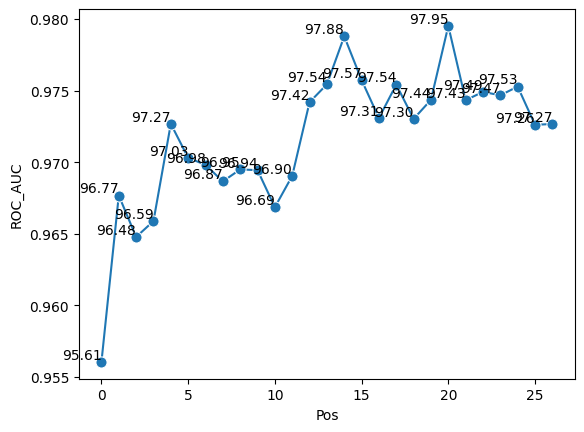

In [181]:
metrics = []
pos = []
for i,j in list(enumerate(metrics_vector)):
    pos.append(i)
    metrics.append(j)

visual_features = pd.DataFrame(columns=["Pos", "ROC_AUC"], index=range(len(metrics)))
visual_features["Pos"] = pos
visual_features["ROC_AUC"] = metrics

ax = sns.lineplot(x="Pos", y="ROC_AUC", data=visual_features, marker='o', markersize=8)

for i, txt in enumerate(metrics):
    ax.text(pos[i], metrics[i], f'{txt*100:.02f}', ha='right', va='bottom')

# Show the plot
plt.show()


In [8]:
df = df[['V4', 'V10', 'V12', 'V14', 'V20', 'Class']]

In [11]:
df.head()

,V4,V10,V12,V14,V20,Class
0,0.272556,0.097945,0.194980,0.667082,-0.170326,0
1,1.065041,-0.492404,-0.110140,-1.324375,0.099626,0
2,1.112353,0.044644,0.188277,0.575710,-0.148044,0
3,-0.015583,-1.007729,0.641899,0.127578,-0.502417,0
4,1.336324,-0.278191,0.811208,0.788272,-0.260697,0


With our features selected, let's explore how they are distributed and related to our Class output. For this, we are using sns heatmap, but before applying it, we should normalize the data, and this will be done using MinMaxScaler.

In [195]:
df_exp = df

features = list(df_exp.columns)
features.remove('Class')

mms = MinMaxScaler()

df_exp[features] = mms.fit_transform(df_exp[features])

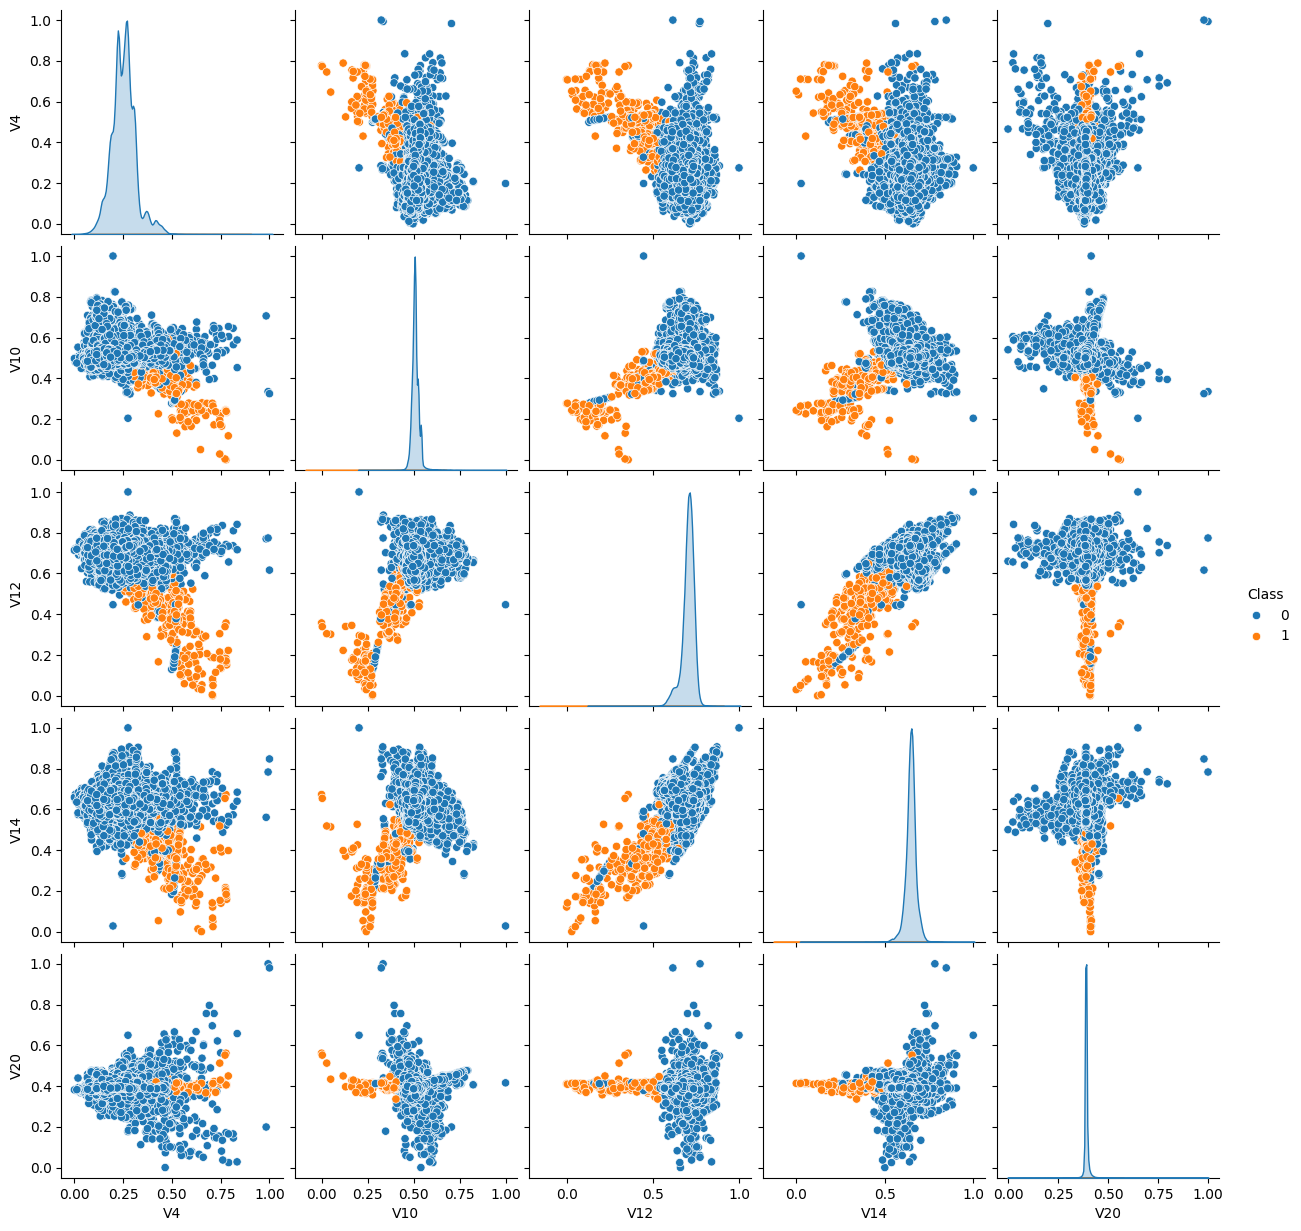

In [196]:
sns.pairplot(data=df_exp, hue="Class")

Various insights can be seen in the pairplot above:

- Fraudulent transactions tend to happen more when, for example, features V14, V12 and V10 assume lower values;

- In every feature combination there is a clear threshold where fraudulent tend to start appearing. One interesting example is when we analyze the relation between V20 and V12: When V12 assumes lower values (in general lower than 0.5), V20 assumes a close to constant value (+- 0.4), and when V12 is above 0.5 V20 can assume a way larger interval of values. Also, when we are below the threshold of V12 = 0.5, there's where V20 assumes a close to constant value AND the fraudulent transactions start ocurring the most. A similar behaviour can be seen when we compare V20 with V14 and V10;

- Among all features, V4 is the one with the biggest standard deviation, which can be seen in the distribution histogram that is slightly larger than the rest;

- V14 and V12 have a slightly linear direct correlation.

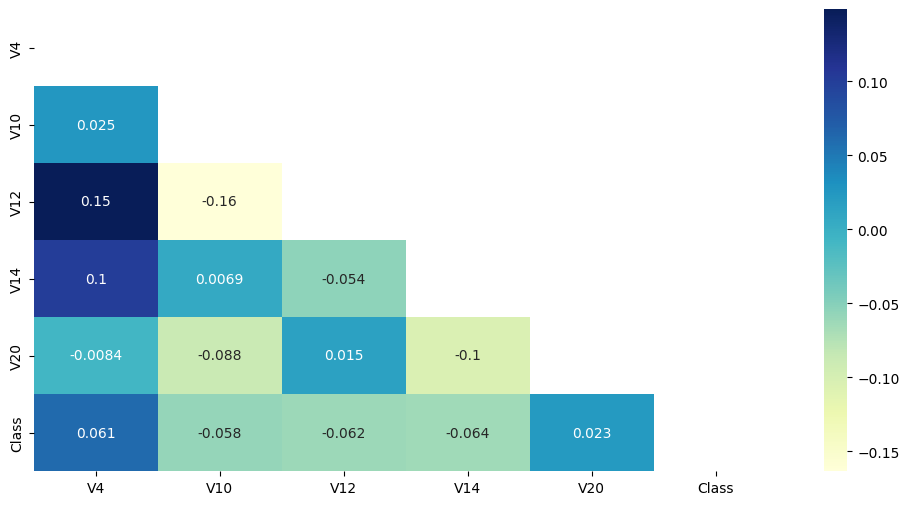

In [197]:
plt.figure(figsize=(12,6))
mask = np.triu(np.ones_like(df_exp.corr()))
dataplot=sns.heatmap(df_exp.corr(method='spearman'), cmap="YlGnBu", annot=True, mask=mask)
plt.show()

The heatmap above shows that there is not any statistically strong correlations between the features.

## Model Selection
Now, we are proceeding to test different classification algorithms. The algorithms we are testing are Random Forest Classifier, LightGBM Classifier, XGBoost Classifier, Support Vector Machine and Decision Tree Classifier. Although tree based moddels do not need to have the features previously normalized, SVC needs. So before fittting and testing each model, we are applying MinMaxScaler.

We are dealing with a binary classificatin problem. For these kind of challenges, there are multiple metrics one can use to check the prediction capacity of a model. However, since we are dealing with an extremely imbalanced dataset, there are some cautions we need to account for. For example, we can't directly use accuracy as a metric in imbalanced problems because this metric will give overly optimisitc results since the majority of our transactions are actually not fraudulent (0).

Before continuing, let's remember some basics of classification problems in machine learning:

- Confusion Matrix: a visualization of how the model's prediction behaved when compared to the real values

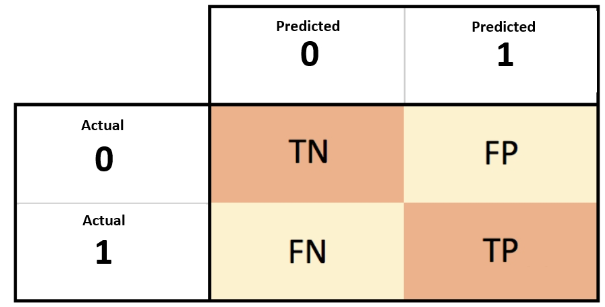

TN = True Negative ; FP = False Positive ; FN = False Negative ; TP = True Positive


- Recall: A metric that shows what fraction of all positive instances the classifier correctly indentifies as positive. Recall is also known as True Positive Rate (TPR) or Sensitivity. Very used when we want to minimize false negatives (recall-oriented tasks).

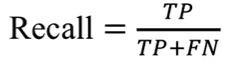


- Precision: A metric that shows what fraction of positive predictions are actually correct. Very used when we want to minimize false positives (precision-oriented tasks).

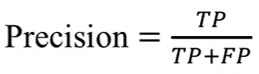


- False Positive Rate (FPR): Metric that informs what fraction of all negative instances the classifier incorrectly identifies as positive

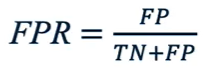

Obs: Specificity = (1 - FPR)


- F1-Score: Metric that combines Precision and Recall. A better overall metric than Accuracy in imbalanced classification problems.

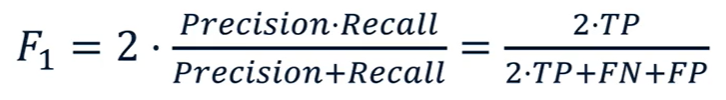


- ROC: Curve that presents the relation when plotting TPR in y axis and FPR in x axis. This curve provides the metric ROC_AUC, which is the area under the ROC. The higher the ROC_AUC, the bigger the "steepness" of the curve and the more "getting the positive instances right" and the less "getting negative instances wrong".

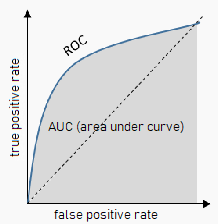


- Precision-Recall curves: Obtained when simply plotting Recall and Precision in order to find the ideal point of prediction threshold that maximizes both prediction and recall.



Here, for each algorithm trained and tested in the stratified cross-validation (k=3) below, we are calculating the metrics Precision, Recall, F1-Score and ROC_AUC. Another thing to point out here is that we are in a Precision-Oriented problem: It is way worse to label a transaction as fraudulent when it is not than the other way around. The client of the financial institution will be let down if a transaction they are trying to make gets labeled and locked as a fraud when it is not, and so, the client might want to leave the institution if this happens frequently. With this, we want to be right when we label the transaction as fraudulent, hence the need to have the best Precision, which will be the main metric to consider here followed by F1-Score.

In [ ]:
x_input = df.drop(['Class'], axis=1)
y_output = df['Class']

ratio = float(y_output.value_counts()[0]) / y_output.value_counts()[1]

k = 3

kf = StratifiedKFold(n_splits=k)

models = {
    "RandomForestClassifier": RandomForestClassifier(class_weight='balanced'), #class_weight as balanced due to extremely imbalanced classes (1 and 0)
    "LightGBMClassifier": LGBMClassifier(verbose=-1, scale_pos_weight=ratio), #giving more weight to positive instances due to imbalance
    "XGBoostClassifier": XGBClassifier(scale_pos_weight=ratio), #giving more weight to positive instances due to imbalance
    "SVMClassifier": SVC(class_weight='balanced'), #class_weight as balanced due to extremely imbalanced classes (1 and 0)
    "DecisionTreeClassifier": DecisionTreeClassifier(class_weight='balanced') #class_weight as balanced due to extremely imbalanced classes (1 and 0)
}

model_metrics = {}

for model_name, model in models.items():
    fold_metrics = {
        "F1-Score": [],
        "Precision": [],
        "ROC_AUC": [],
        "Recall": []
    }

    for train_index, val_index in kf.split(x_input, y=y_output):
        X_train_fold, X_val_fold = x_input.iloc[train_index], x_input.iloc[val_index]
        y_train_fold, y_val_fold = y_output.iloc[train_index], y_output.iloc[val_index]

        mme = MinMaxScaler()

        X_train_fold = mme.fit_transform(X_train_fold)
        X_val_fold = mme.transform(X_val_fold)

        model.fit(X_train_fold, y_train_fold.values.ravel())
        y_pred = model.predict(X_val_fold)

        f1 = f1_score(y_val_fold, y_pred)
        precision = precision_score(y_val_fold, y_pred)
        roc_auc = roc_auc_score(y_val_fold, y_pred)
        recall = recall_score(y_val_fold, y_pred)

        fold_metrics["F1-Score"].append(f1)
        fold_metrics["Precision"].append(precision)
        fold_metrics["ROC_AUC"].append(roc_auc)
        fold_metrics["Recall"].append(recall)

    mean_metrics = {
        "F1-Score": np.mean(fold_metrics["F1-Score"]),
        "Precision": np.mean(fold_metrics["Precision"]),
        "ROC_AUC": np.mean(fold_metrics["ROC_AUC"]),
        "Recall": np.mean(fold_metrics["Recall"])
    }

    model_metrics[model_name] = mean_metrics

In [26]:
model_metrics

{'RandomForestClassifier': {'F1-Score': 0.8293588935547914,
  'Precision': 0.9367775097752215,
  'ROC_AUC': 0.8730907173682395,
  'Recall': 0.7462686567164178},
 'LightGBMClassifier': {'F1-Score': 0.09271745367618141,
  'Precision': 0.05336756424641471,
  'ROC_AUC': 0.849882340214695,
  'Recall': 0.8532338308457712},
 'XGBoostClassifier': {'F1-Score': 0.8554636797247634,
  'Precision': 0.9066588209482233,
  'ROC_AUC': 0.905402028546446,
  'Recall': 0.8109452736318407},
 'SVMClassifier': {'F1-Score': 0.15219361728135253,
  'Precision': 0.08342475635475965,
  'ROC_AUC': 0.9345062116989657,
  'Recall': 0.8855721393034827},
 'DecisionTreeClassifier': {'F1-Score': 0.7264827213092581,
  'Precision': 0.7368024294231459,
  'ROC_AUC': 0.8592346813685606,
  'Recall': 0.7189054726368159}}

In [24]:
# saving the cv results for later on analysis

with open("cv_results.json", "w") as json_file:
        json.dump(model_metrics, json_file)

In [11]:
model_metrics = json.load(open('cv_results.json'))

In [12]:
rows = []

for model, metrics in model_metrics.items():
    for metric, value in metrics.items():
        rows.append([model, metric, value])

metrics_df = pd.DataFrame(rows, columns=['Model name', 'Metric name', 'Metric value'])

After saving the results, let's analyze them, remembering that we tested each algorithm with their standard hyperparameteres. First, in the df below one can see that in terms of Precision, the best models were Random Forest and XGBoost.

When checking the visuals, we can also check that in terms of the metrics Recall and ROC_AUC the models performed similarly, however, in terms of PRecision and F1-Score, which are the metrics we chose for our comparison, Random Forest and XGBoost had a way better behaviour when compared to the other algorithms. Therefore, we will proceed to fine-tune these two models.

In [29]:
Metric_see = 'Precision'

metrics_df.loc[metrics_df["Metric name"] == Metric_see].sort_values(by=["Metric value"], ascending=False)

,Model name,Metric name,Metric value
1,RandomForestClassifier,Precision,0.936778
9,XGBoostClassifier,Precision,0.906659
17,DecisionTreeClassifier,Precision,0.736802
13,SVMClassifier,Precision,0.083425
5,LightGBMClassifier,Precision,0.053368


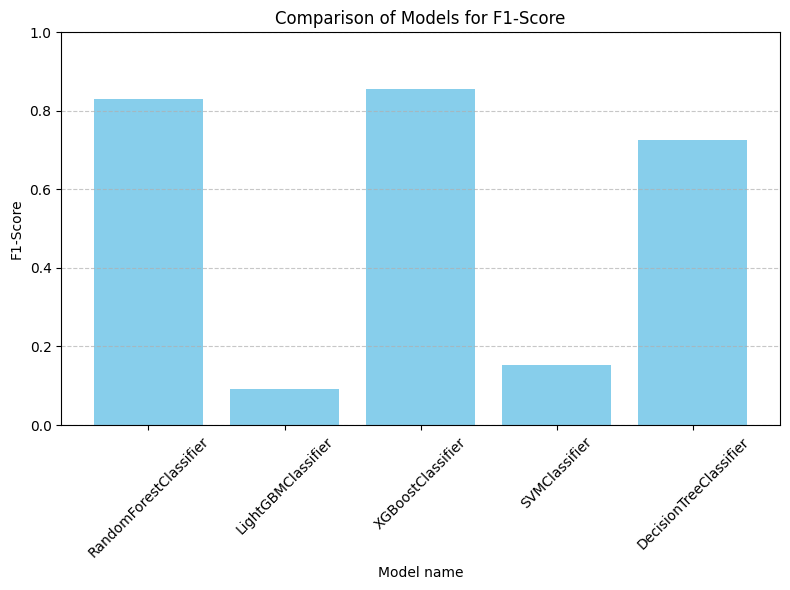

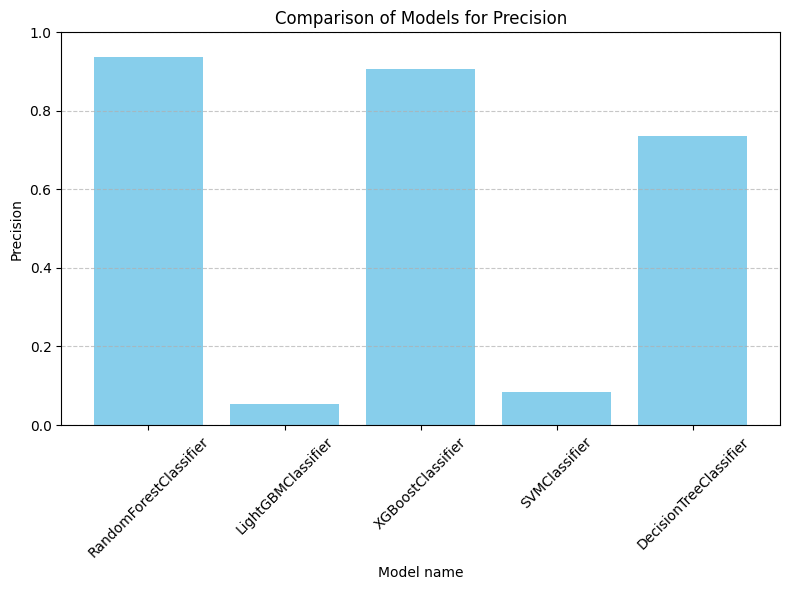

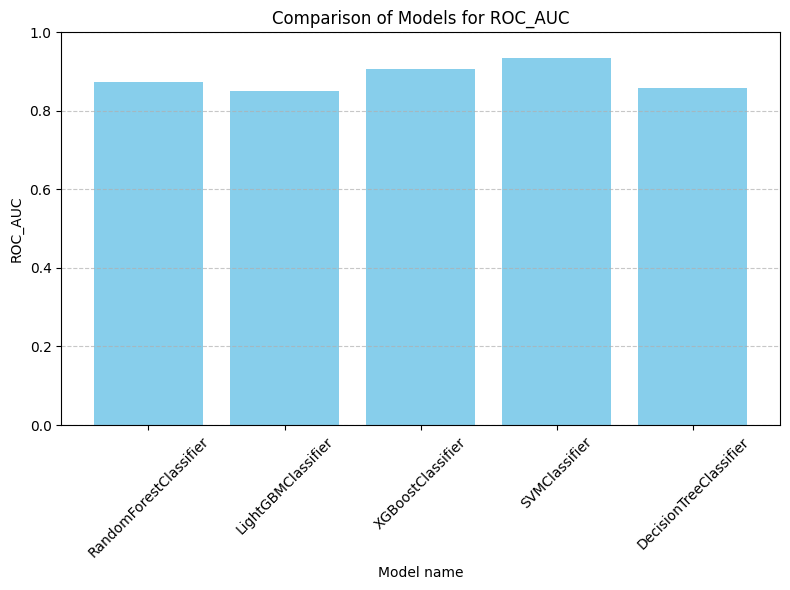

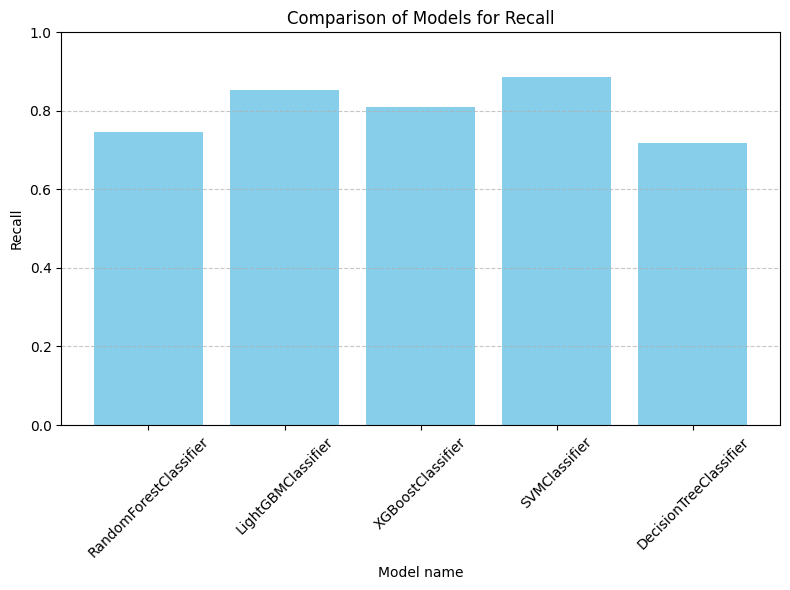

In [28]:
# Group the DataFrame by the 'Metric' column
grouped_df = metrics_df.groupby('Metric name')

# Plot a bar graph for each metric
for metric, group in grouped_df:
    plt.figure(figsize=(8, 6))
    plt.bar(group['Model name'], group['Metric value'], color='skyblue')
    plt.title(f'Comparison of Models for {metric}')
    plt.xlabel('Model name')
    plt.ylabel(metric)
    plt.ylim(0, 1)  # Set the y-axis limit (adjust as needed)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

Below, a complete report of the metrics obtained with the stratified cross-validation.

In [31]:
metrics_df

,Model name,Metric name,Metric value
0,RandomForestClassifier,F1-Score,0.829359
1,RandomForestClassifier,Precision,0.936778
2,RandomForestClassifier,ROC_AUC,0.873091
3,RandomForestClassifier,Recall,0.746269
4,LightGBMClassifier,F1-Score,0.092717
5,LightGBMClassifier,Precision,0.053368
6,LightGBMClassifier,ROC_AUC,0.849882
7,LightGBMClassifier,Recall,0.853234
8,XGBoostClassifier,F1-Score,0.855464
9,XGBoostClassifier,Precision,0.906659


Once again using the models' standard hyperparameters, let's take a deeper dive into the comparison between the performance between Random Forest and XGBoost. Let's compare both models' Classification Reports, Confusion Matrix, Learning Curve and ROC.

The learning curve plots the model's performance (in our case here measured by the f1-score) with training and validation data according to the addition of data points to train the model, so we can track how the model is performing during training. This also helps us check if there is any overfitting or underfitting happening.

Training and evaluating XGB Classifier...


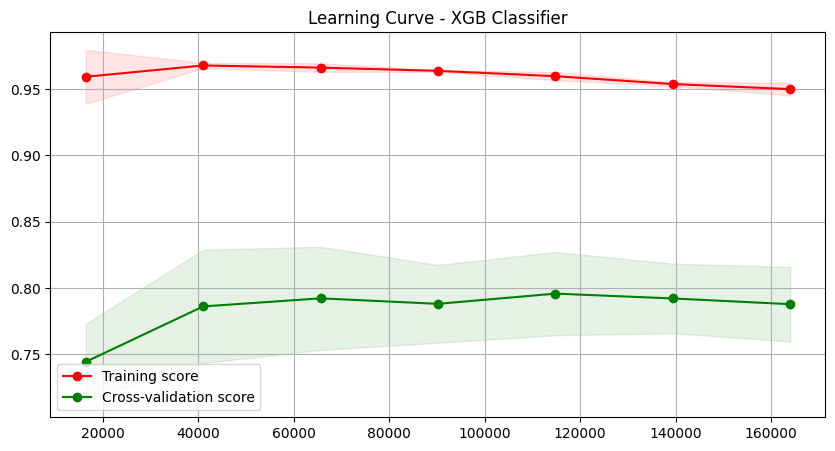


Classification Report for XGB Classifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36116
           1       0.74      0.85      0.79        60

    accuracy                           1.00     36176
   macro avg       0.87      0.92      0.90     36176
weighted avg       1.00      1.00      1.00     36176



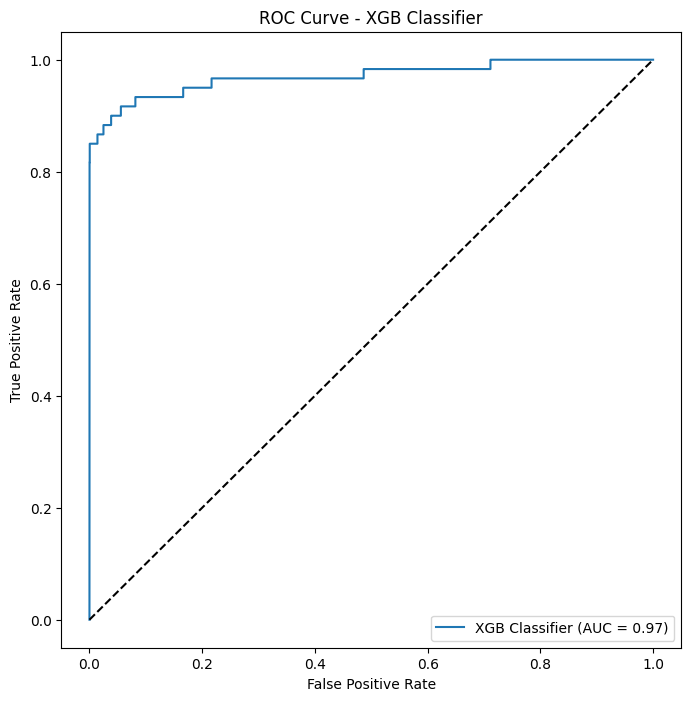


Confusion Matrix for XGB Classifier:

[[36098    18]
 [    9    51]]
Training and evaluating RandomForestClassifier...


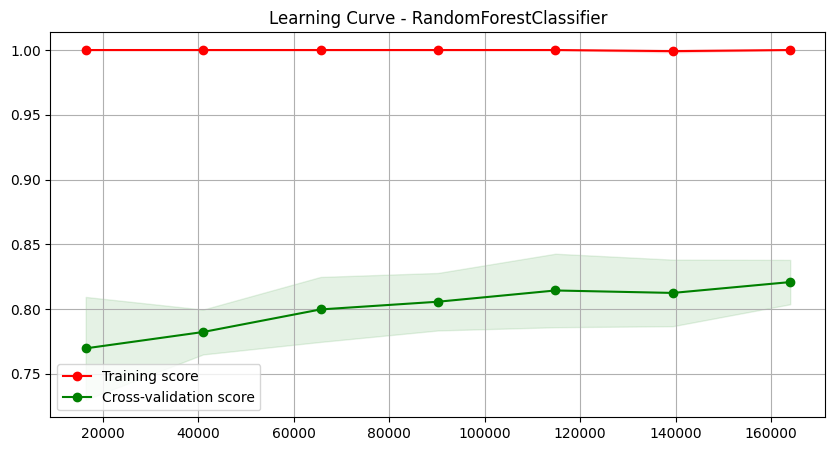


Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36116
           1       0.93      0.83      0.88        60

    accuracy                           1.00     36176
   macro avg       0.96      0.92      0.94     36176
weighted avg       1.00      1.00      1.00     36176



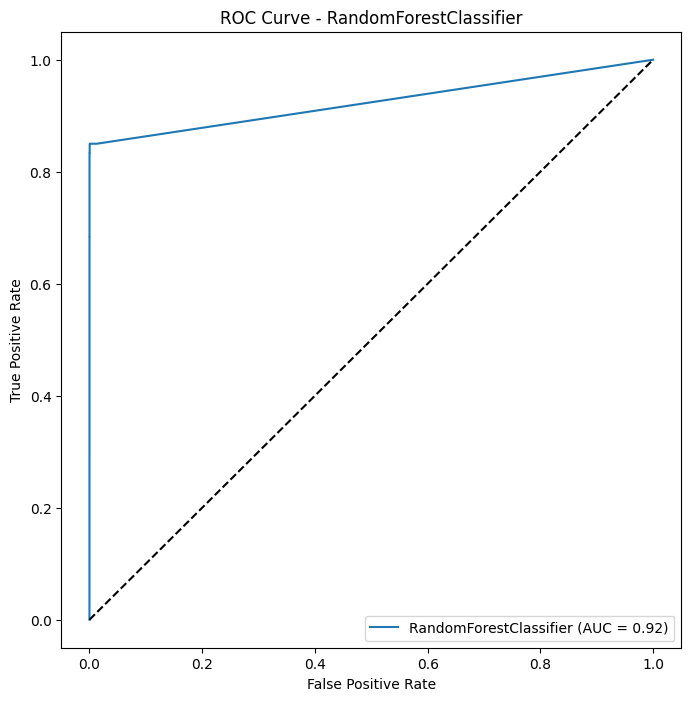


Confusion Matrix for RandomForestClassifier:

[[36112     4]
 [   10    50]]


In [41]:
def plot_learning_curve(estimator, X, y, axes=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 7)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 5))

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='f1')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    axes.legend(loc="best")
    return plt



X = df.drop(['Class'], axis=1)
y = df['Class']

ratio = float(y_output.value_counts()[0]) / y_output.value_counts()[1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=df["Class"], random_state=42)


classifiers = {
    "XGB Classifier": XGBClassifier(scale_pos_weight=ratio),
    "RandomForestClassifier": RandomForestClassifier(class_weight='balanced')
}


for name, classifier in classifiers.items():
    print(f"Training and evaluating {name}...")

    
    classifier.fit(X_train, y_train)

    
    plot_learning_curve(classifier, X_train, y_train)
    plt.title(f"Learning Curve - {name}")
    plt.show()

    
    y_pred = classifier.predict(X_test)

    
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    
    fpr, tpr, thresholds = roc_curve(y_test, classifier.predict_proba(X_test)[:, 1])
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, classifier.predict_proba(X_test)[:, 1]):.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc='lower right')
    plt.show()

    
    print(f"\nConfusion Matrix for {name}:\n")
    print(confusion_matrix(y_test, y_pred))

    print("=" * 50)


By analyzing the results above we can see that, eventhough XGBoost classifier got a bigger ROC_AUC, Random Forest has a higher precision value regarding the positive class (1) (and f1-score also). Also, Random Forest's learning curve demonstrates a better learning behaviour: Random Forest reaches the f1-score with less than 80000 training instances, while xgboost does not reach this value even with all data points. Also, XGBoost shows a validation curve stabilization, whiler Random Forest keeps increasing its performance when adding more data points. In the future, when adding more data points to the training database, XGBoost could start experiencing overfitting earlier.

Also, although XGBoost got one more real positive instance correct than Random Forest, XGBoost also wrongly pointed out 14 non fraudulent transactions more than Random Forest.

With this being said, we will proceed to train and add to production the Random Forest model.

Having selected Random Forest as the go to model for this challenge, let's try to do some fine tuning. We are testing the hyperparameters n_estimators, max_depth, ccp_alpha and max_features, which are commonly tuned hyperparameters in Random Forest models.

However, interestingly, the results using CVGridSearch show that the best hyperparameters, among the values tested, are actually the stardard ones!

Therefore, we will proceed with further modeling using Random Forest standard hyperparameters (but keeping the class_weight as balanced due to the extreme imbalance).

In [42]:
X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.60, stratify=df["Class"], random_state=42)

params = { 'n_estimators': [50, 100, 150, 300],
           'max_depth': [None, 10, 100],
           'random_state': [42],
           'class_weight': ['balanced'],
           'ccp_alpha': [0, 0.001, 0.01],
           'max_features': ['sqrt', 'log2', None],
         }

grid_search = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=3, n_jobs=-1, scoring='precision')
grid_search.fit(X_train, y_train.values.ravel())
print("\nBest Parameters according to Grid Search:", grid_search.best_params_)


Best Parameters according to Grid Search: {'ccp_alpha': 0, 'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}


When dealing with an imbalanced classification problem, we must also check if we have the best classification threshold. Normally, Random Forest utilizes the probability of 0.5 to see if an instance belongs to the positive or negative class (in the case of binary classification).

In order to study and see what is the best threshold, we can use the precision-recall curve to find the best threshold that finds the optimal point that balances the trade-off between the best precision and best recall. In order to judge the best point regarding this trade-off, we will check what is the threshold that gives the max f1-score.

The threshold found was 0.43 (notice that it is not 0.5 anymore).

Best Threshold: 0.43


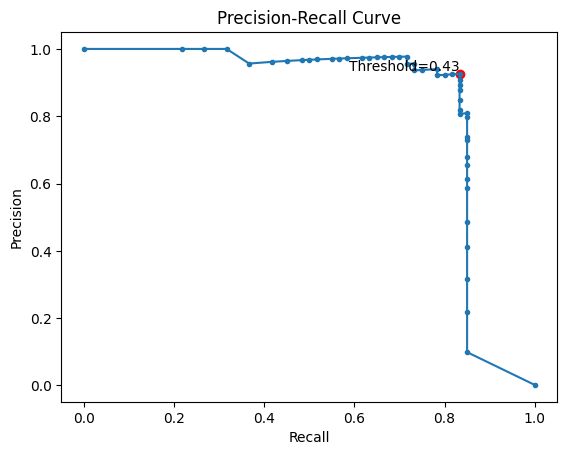

In [45]:
X = df.drop(['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=df["Class"], random_state=42)

classifier = RandomForestClassifier(class_weight='balanced').fit(X_train, y_train)

y_proba = classifier.predict_proba(X_test)[:, 1] 

precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

plt.scatter(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], color='red')
plt.text(recall[np.argmax(f1_scores)], precision[np.argmax(f1_scores)], f'Threshold={best_threshold:.2f}', verticalalignment='bottom', horizontalalignment='right')

print("Best Threshold:", best_threshold)
plt.show()

Let's see how the model performs using the new threshold of 0.43

In [9]:
def random_forest_clf(threshold, X, clf):
    y_proba = clf.predict_proba(X)[:, 1]
    y_pred = np.where(y_proba >= threshold, 1, 0)
    return y_pred

In [48]:
X = df.drop(['Class'], axis=1)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, stratify=df["Class"], random_state=42)

# Define classifiers
classifiers = {
    "RandomForestClassifier": RandomForestClassifier(class_weight='balanced')
}

# Iterate through classifiers
for name, classifier in classifiers.items():
    print(f"Training and evaluating {name}...")

    # Train the model
    classifier.fit(X_train, y_train)

    # Generate predictions on test set
    y_pred = random_forest_clf(0.43, X_test, clf=classifier)

    # Display classification report
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, y_pred))

    # Display confusion matrix
    print(f"\nConfusion Matrix for {name}:\n")
    print(confusion_matrix(y_test, y_pred))

    print("=" * 50)


Training and evaluating RandomForestClassifier...

Classification Report for RandomForestClassifier:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     36116
           1       0.93      0.83      0.88        60

    accuracy                           1.00     36176
   macro avg       0.96      0.92      0.94     36176
weighted avg       1.00      1.00      1.00     36176


Confusion Matrix for RandomForestClassifier:

[[36112     4]
 [   10    50]]


Not that different when comparing with the previous original results, though. But we will proceed with the new threshold.

## Testing on unseen data
Now let's return to the testing data that we set aside when we started the whole study and see how our model performs (this performance will be assumed for the model in production).

In [10]:
df_test = pd.read_csv(r'C:\Users\artur\class_transactions\data\testing_data.csv')
df_test = df_test[['V4', 'V10', 'V12', 'V14', 'V20', 'Amount', 'Class']]
X_test = df_test[['V4', 'V10', 'V12', 'V14', 'V20']]
y_test = df_test[["Amount", "Class"]]

X = df.drop(['Class'], axis=1)
y = df['Class']

clf = RandomForestClassifier(class_weight='balanced').fit(X, y)

y_pred = random_forest_clf(0.43, X_test, clf=clf)

In [50]:
print(f"\nClassification Report with Test data:\n")
print(classification_report(y_test['Class'].values, y_pred))

print(f"\nConfusion Matrix with Test data:\n")
print(confusion_matrix(y_test['Class'].values, y_pred))


Classification Report with Test data:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     42488
           1       0.90      0.73      0.81        71

    accuracy                           1.00     42559
   macro avg       0.95      0.87      0.90     42559
weighted avg       1.00      1.00      1.00     42559


Confusion Matrix with Test data:

[[42482     6]
 [   19    52]]


Nice!

Our model performed very well on the unseen data! We got a precision of 0.90 and f1-score of 0.81.

Also, we can calculate the financial gain the model could bring, considering that an avoided fraudulent transaction (the model predicting as fraudulent an actually fraudulent transaction) is a financial gain to the institution. The value considering the testing data is stated below.

In [11]:
y_test['predicted'] = y_pred

eur_prevented = np.sum(y_test['Amount'].loc[(y_test["Class"]==1) & (y_test['predicted']==1)].values)
print(f"Considering the Testing (unseen) data, the model's prediction could have avoided the transaction of {eur_prevented:.02f} EUR in fraudulent transactions")

Considering the Testing (unseen) data, the model's prediction could have avoided the transaction of 7402.10 EUR in fraudulent transactions


In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

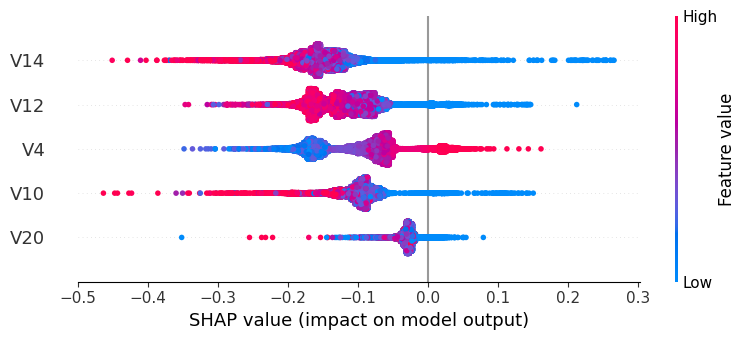

In [32]:
shap.summary_plot(shap_values[:, :, 1], X_test)

Explainability is a must nowadays. Using the SHAP lib, let's see how each feature influences the prediction if a transaction is a fraud or not:

- Of the selected features, V14 is the one that 'explains' the most the Class output, while V20 is the least informative;

- In general, lower values of V14, V12, V10 and V20 point out to a higher probability that the transaction is a fraud;

- Also in general, higher values of V4 point out to a higher probability that the transaction is a fraud;